In [1]:
import time
import numpy as np
from numba import typed
from pyloki.simulation.pulse import PulseSignalConfig
from pyloki.config import PulsarSearchConfig
from pyloki.ffa import DynamicProgramming
from pyloki.periodogram import Periodogram
from pyloki.detection import scoring, thresholding
from pyloki.utils import np_utils
from pyloki.prune import Pruning
from matplotlib import pyplot as plt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


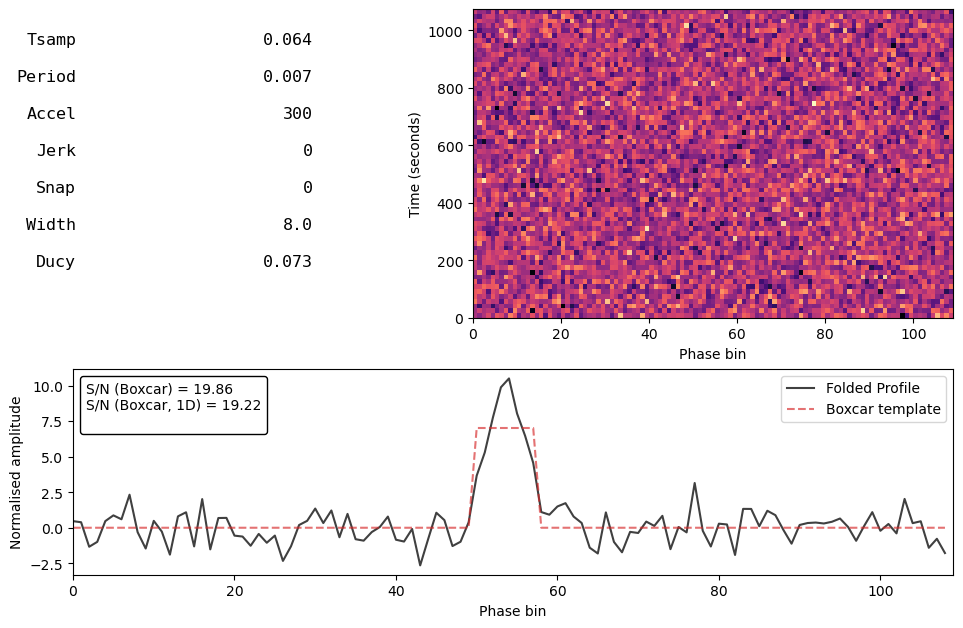

In [2]:
pulsar_period = 0.007
dt = 64e-6
accel = 300
nsamps = 2**24
mod_kwargs = {"acc": accel}

cfg = PulseSignalConfig(period=pulsar_period, dt=dt, nsamps=nsamps, snr=20, ducy=0.1, mod_kwargs=mod_kwargs)
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs); plt.show()

In [3]:
tol_bins = cfg.tol_bins
fold_bins = cfg.fold_bins

tol_bins = 4
#fold_bins = 64
param_limits = typed.List([(100.0, 500.0), (1/0.008, 1/0.006)])
bseg_ffa = cfg.nsamps // 64
search_cfg = PulsarSearchConfig(cfg.nsamps, cfg.dt, fold_bins, tol_bins, param_limits, bseg_ffa=bseg_ffa, prune_poly_order=2)
dyp = DynamicProgramming(tim_data, search_cfg)
dyp.initialize()
dyp.execute()

2024-09-11 01:17:49 INFO     - pyloki.ffa - Initializing data structure...

2024-09-11 01:17:50 INFO     - pyloki.ffa - param steps: [8.93451148e+06 1.43268036e-01]

2024-09-11 01:17:55 INFO     - pyloki.ffa - fold dimensions: (4096, 1, 290, 2, 109)

                    INFO     - pyloki.ffa - ffa_initialize finished, Elapsed time: 5.796 seconds

                    INFO     - pyloki.ffa - param steps: [2.23362787e+06 7.08047412e-02]

2024-09-11 01:17:57 INFO     - pyloki.ffa - i_iter: 1, fold dims: (2048, 1, 588, 2, 109)

                    INFO     - pyloki.ffa - param steps: [5.58406968e+05 3.51986308e-02]

                    INFO     - pyloki.ffa - i_iter: 2, fold dims: (1024, 1, 1183, 2, 109)

                    INFO     - pyloki.ffa - param steps: [1.39601742e+05 1.75488189e-02]

2024-09-11 01:17:58 INFO     - pyloki.ffa - i_iter: 3, fold dims: (512, 1, 2374, 2, 109)

                    INFO     - pyloki.ffa - param steps: [3.49004355e+04 8.76183957e-03]

                    INFO     - pyloki.ffa - i_iter: 4, fold dims: (256, 1, 4755, 2, 109)

                    INFO     - pyloki.ffa - param steps: [8.72510887e+03 4.37778406e-03]

                    INFO     - pyloki.ffa - i_iter: 5, fold dims: (128, 1, 9517, 2, 109)

                    INFO     - pyloki.ffa - param steps: [2.18127722e+03 2.18810894e-03]

                    INFO     - pyloki.ffa - i_iter: 6, fold dims: (64, 1, 19042, 2, 109)

                    INFO     - pyloki.ffa - ffa_execute finished, Elapsed time: 3.029 seconds

In [4]:
target_snr = 10
thresholds = thresholding.bound_scheme(dyp.nsegments, target_snr)
prn = Pruning(dyp, thresholds, max_sugg=2**19)
res = prn.execute(snr_lim=10)

2024-09-11 01:17:59 INFO     - pyloki.prune - Initializing pruning with ref segment: 0

2024-09-11 01:18:01 INFO     - pyloki.prune - prune_initialize finished, Elapsed time: 2.840 seconds

Output()

In [5]:
from pyloki.utils.misc import C_VAL
delta_t = (prn.scheme.ref - prn.scheme.get_coord(prn.prune_level)[0]) * prn.dyp.tseg
acc_prune_ref = cfg.mod_kwargs["acc"]
vel_prune_ref = cfg.mod_kwargs["acc"] * delta_t
freq_prune_ref = cfg.freq * (1 + vel_prune_ref / C_VAL)
print(f"True params, a: {acc_prune_ref:.3f}, f: {freq_prune_ref:.10f}")

nresults = 10
res_inds = np.argsort(prn.suggestion.scores)[-nresults:][::-1]
print(f"da: {prn.suggestion.param_sets[0][0,1]}, dp: {prn.suggestion.param_sets[0][1,1]},")
for idx in res_inds:
    param = prn.suggestion.param_sets[idx]
    snr = prn.suggestion.scores[idx]
    print(f"idx: {idx}, a: {param[0,0]:.3f}, f: {param[1,0]:.10f}, S/N: {snr:.2f}")

True params, a: 300.000, f: 142.7815931193
da: 0.5486968449931414, dp: 2.7013690648312256e-05,
idx: 43, a: 300.000, f: 142.7816384188, S/N: 17.45
idx: 44, a: 300.000, f: 142.7816654325, S/N: 16.95
idx: 42, a: 300.000, f: 142.7816114051, S/N: 16.21
idx: 35, a: 300.000, f: 142.7815843914, S/N: 15.67
idx: 36, a: 300.549, f: 142.7815303640, S/N: 14.87
idx: 34, a: 300.000, f: 142.7815573777, S/N: 14.30
idx: 45, a: 300.549, f: 142.7816114051, S/N: 14.09
idx: 40, a: 299.451, f: 142.7816384188, S/N: 14.04
idx: 41, a: 299.451, f: 142.7816654325, S/N: 13.96
idx: 39, a: 299.451, f: 142.7816114051, S/N: 13.92


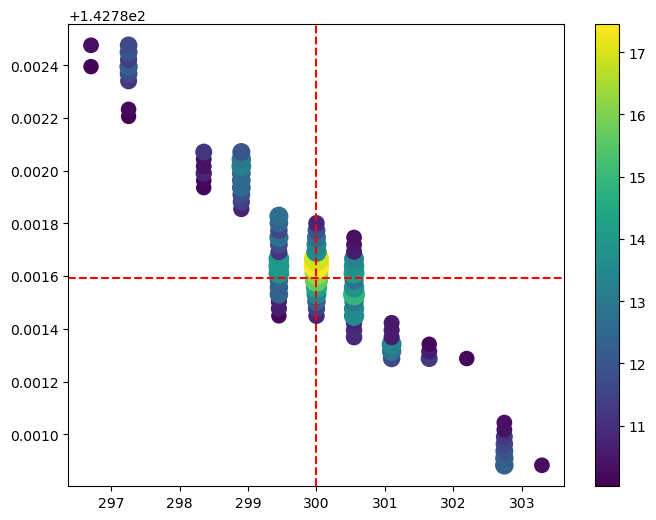

In [6]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
im = ax.scatter(prn.suggestion.param_sets[:, :, 0][:, 0], prn.suggestion.param_sets[:, :, 0][:, 1], 
                c=prn.suggestion.scores, s=prn.suggestion.scores**2)
ax.axhline(freq_prune_ref, c="r", ls="--")
ax.axvline(acc_prune_ref, c="r", ls="--")
plt.colorbar(im, ax=ax)
plt.show()

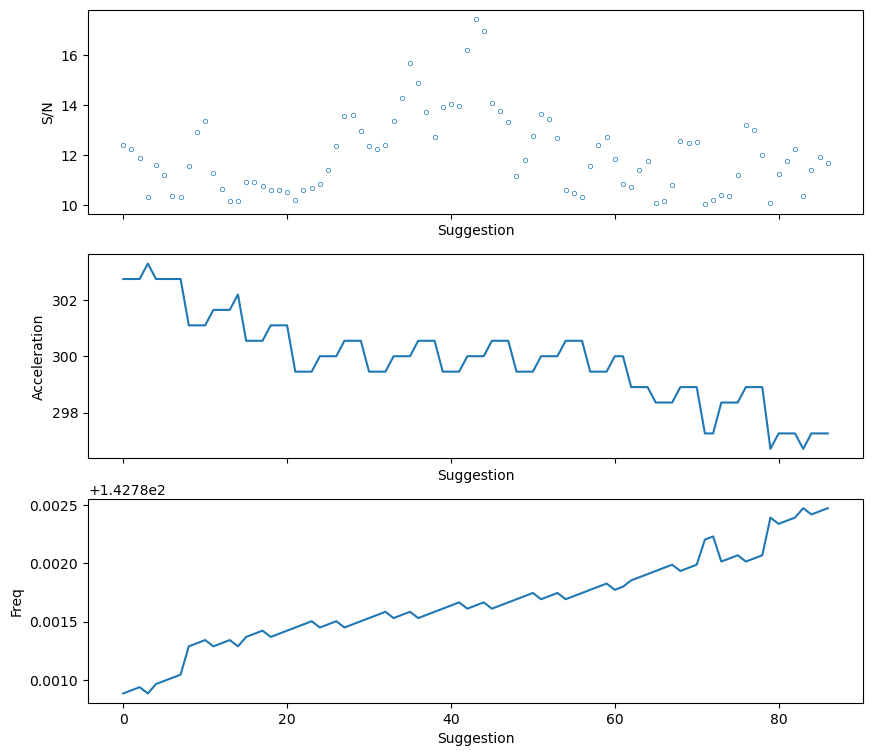

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 9), dpi=100)
ax1.scatter(np.arange(prn.suggestion.size), prn.suggestion.scores, s=10, edgecolor="tab:blue", facecolor="white",linewidth=0.5)
ax1.set_xlabel("Suggestion")
ax1.set_ylabel("S/N")
ax2.plot(np.arange(prn.suggestion.size), prn.suggestion.param_sets[:, :, 0][:,0])
ax2.set_xlabel("Suggestion")
ax2.set_ylabel("Acceleration")
ax3.plot(np.arange(prn.suggestion.size), prn.suggestion.param_sets[:, :, 0][:,1])
ax3.set_xlabel("Suggestion")
ax3.set_ylabel("Freq")
plt.show()